In [2]:
import re
import os, csv, sys 
import scipy
import pandas as pd
import gzip
import xml.etree.ElementTree as ET
from os import listdir
from datetime import datetime
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import random
from netCDF4 import Dataset
import itertools

In [38]:
## Parameters

cyclone_names = ['vongfong']
data_folder = '../../data/CSVS/'
results_folder = '../../results/CSVs/'
figures_folder = '../../results/figures/'
for folder_name in [data_folder, results_folder, figures_folder]:
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

In [8]:
os.getcwd()

'C:\\Users\\ATeklesadik\\OneDrive - Rode Kruis\\Documents\\documents\\Typhoon-Impact-based-forecasting-model\\skill_analysis\\new_code\\jupyter_notebooks'

## Create pandaframe from xml files

In [ ]:
## Parameters


In [40]:
# Create folders

        
# Initialise lists

file_list = []
file_list_short = []
list_failed1 = []
list_total = []
institutes = []
    


df_store=pd.read_csv(os.path.join(data_folder,'mangkhut_all.csv'))  
df_store[(df_store.Mtype=='forecast')& (df_store.model_name=='ecmwf')]

C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Mtype,institute_name,product,model_name,basin,cycloneName,cycloneName2,cycloneNumber,ensemble,cyc_speed,cyc_cat,time,lat,lon,vhr,forecast_time
1,forecast,ecmf,ecmwf,ecmwf,northwest pacific,mangkhut,abel:beth,29.0,none,18.5,NaN,"2018/09/08, 00:00:00",13.7,162.1,0,"2018/09/08, 00:00:00"
2,forecast,ecmf,ecmwf,ecmwf,northwest pacific,mangkhut,abel:beth,29.0,none,19.5,NaN,"2018/09/08, 06:00:00",13.9,160.3,6,"2018/09/08, 00:00:00"
3,forecast,ecmf,ecmwf,ecmwf,northwest pacific,mangkhut,abel:beth,29.0,none,21.1,NaN,"2018/09/08, 12:00:00",14.4,158.9,12,"2018/09/08, 00:00:00"
4,forecast,ecmf,ecmwf,ecmwf,northwest pacific,mangkhut,abel:beth,29.0,none,20.1,NaN,"2018/09/08, 18:00:00",14.7,157.2,18,"2018/09/08, 00:00:00"
5,forecast,ecmf,ecmwf,ecmwf,northwest pacific,mangkhut,abel:beth,29.0,none,20.1,NaN,"2018/09/09, 00:00:00",14.8,155.2,24,"2018/09/08, 00:00:00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22633,forecast,ecmf,ecmwf,ecmwf,northwest pacific,mangkhut,abel:beth,29.0,none,14.4,NaN,"2018/09/17, 00:00:00",22.8,108.8,0,"2018/09/17, 00:00:00"
22634,forecast,ecmf,ecmwf,ecmwf,northwest pacific,mangkhut,abel:beth,29.0,none,11.8,NaN,"2018/09/17, 06:00:00",23.5,107.2,6,"2018/09/17, 00:00:00"
22635,forecast,ecmf,ecmwf,ecmwf,northwest pacific,mangkhut,abel:beth,29.0,none,10.3,NaN,"2018/09/17, 12:00:00",23.8,106.6,12,"2018/09/17, 00:00:00"
22636,forecast,ecmf,ecmwf,ecmwf,northwest pacific,mangkhut,abel:beth,29.0,none,9.8,NaN,"2018/09/17, 18:00:00",23.8,106.1,18,"2018/09/17, 00:00:00"


## Structure the results as a dictionary

Create a dictionary out of the results, with the following sctructure:

- number identifying institute and model:
    - institute-model name
    - cyclone name
        - forecast
            - start (date and time at which the forecast was started)
            - lat (list of latitudes of the path)
            - lon (list of longitudes of the path)
        - ensemble
            - start
            - lat
            - lon
        - ensemble_mean
            - start
            - lat
            - lon
        - number_members_ensemble

In [44]:
## Parameters

time_limit = 72
time_separation = 6

In [46]:
# Initialise the dictonary
results = {}

# Create a list with time points
nhours_list = list(np.linspace(0,time_limit,int(time_limit/time_separation)+1, dtype=int))

# Retrieve model names from the dataframe (the function set removes duplicates from a list)
institute_names = list(set(df_store['institute_name']))

# Initialise model_num (so that the first number will actually be 0)
model_num = -1

In [47]:


# Loop over institutes
for institute_name in institute_names:
    
    # Restrict the dataframe to the specific institute
    df_institute = df_store[df_store['institute_name'] == institute_name]
    
    # Retrieve model names from the dataframe (the function set removes duplicates from a list)
    model_names = list(set(df_institute['model_name']))
    
    print(model_names)
    
    # Loop over models
    for model_name in model_names:
        
        model_num += 1
    
        # Initialise subdictionary and assign name
        results[str(model_num)] = {}
        results[str(model_num)]['model_name'] = institute_name.upper()+' - '+model_name
        
        print(model_num, results[str(model_num)]['model_name'])

        # Restrict the dataframe to the specific model
        df_model = df_institute[df_institute['model_name'] == model_name]

        # Loop over cyclone names
        for cyclone_name in cyclone_names:

            # Initialise subdictionary
            results[str(model_num)][cyclone_name] = {}
            
            # Initialise subdictionary initial points
            results[str(model_num)][cyclone_name]['initial'] = {}

            # Restrict the dataframe to the specific cyclone
            df_cyclone = df_model[df_model['cycloneName']==cyclone_name]

            # Restrict the dataframe to the analysis
            df_analysis = df_cyclone[df_cyclone['Mtype'] == 'analysis']
            
            # Store lats and lons initial point
            results[str(model_num)][cyclone_name]['initial']['analysis'] = {}
            try:
                results[str(model_num)][cyclone_name]['initial']['analysis']['coord'] = [float(df_analysis['lat']),float(df_analysis['lon'])]
                results[str(model_num)][cyclone_name]['initial']['analysis']['date'] = list(df_analysis['forecast_time'])[0]
            except:
                results[str(model_num)][cyclone_name]['initial']['analysis']['coord'] = [0,0]
                results[str(model_num)][cyclone_name]['initial']['analysis']['date'] = 'nan'
            
            # Initialise subdictionary forecast
            results[str(model_num)][cyclone_name]['forecast'] = {}

            # Restrict the dataframe to the forecasts
            df_forecast = df_cyclone[df_cyclone['Mtype'] == 'forecast']

            # Initialise lists for lat and lon of paths
            lat_forecast = []
            lon_forecast = []

            # Loop over time points
            for nhours in nhours_list:
                # Assign lat and lon
                try:
                    lat_forecast.append(float(df_forecast[df_forecast['vhr']==str(nhours)]['lat']))
                    lon_forecast.append(float(df_forecast[df_forecast['vhr']==str(nhours)]['lon']))
                except:
                    lat_forecast.append(np.nan)
                    lon_forecast.append(np.nan)

            # Assign starting point ('validt2' in the dataframe)
            try:
                results[str(model_num)][cyclone_name]['forecast']['start'] = list(df_forecast['forecast_time'])[0]
            except:
                results[str(model_num)][cyclone_name]['forecast']['start'] = ''

            # Store lats and lons in the dictonary
            results[str(model_num)][cyclone_name]['forecast']['lat'] = np.array(lat_forecast)
            results[str(model_num)][cyclone_name]['forecast']['lon'] = np.array(lon_forecast)
            
            # Store lats and lons initial point
            results[str(model_num)][cyclone_name]['initial']['forecast'] = {}
            try:
                results[str(model_num)][cyclone_name]['initial']['forecast']['coord'] = [float(df_forecast[df_forecast['vhr']==str(0)]['lat']),float(df_forecast[df_forecast['vhr']==str(0)]['lon'])]
                results[str(model_num)][cyclone_name]['initial']['forecast']['date'] = list(df_forecast['forecast_time'])[0]
            except:
                results[str(model_num)][cyclone_name]['initial']['forecast']['coord'] = [0,0]
                results[str(model_num)][cyclone_name]['initial']['forecast']['date'] = 'nan'
                
            # Initialise subdictionary ensembles
            results[str(model_num)][cyclone_name]['ensemble'] = {}

            # Initialise lists for lat and lon of paths
            lat_ensemble_list = []
            lon_ensemble_list = []

            # Restrict the dataframe to the ensemble forecasts
            df_ensemble = df_cyclone[df_cyclone['Mtype'] == 'ensembleforecast']

            # For each model, each cyclone, retrieve the list of ensembles
            ensemble_list = sorted([int(x) for x in list(set(df_ensemble['ensemble']))])
            results[str(model_num)][cyclone_name]['num_members_ensemble'] = len(ensemble_list)

            # Initialise lists for initial points ensemble
            results[str(model_num)][cyclone_name]['initial']['ensemble'] = {}
            results[str(model_num)][cyclone_name]['initial']['ensemble']['coord'] = []
            results[str(model_num)][cyclone_name]['initial']['ensemble']['date'] = []
            
            # Loop over the member of the ensemble
            for member in ensemble_list:

                # Restrict the dataframe to the ensemble
                df_member = df_ensemble[df_ensemble['ensemble'] == str(member)]
                
                # Store lats and lons initial point
                try:
                    results[str(model_num)][cyclone_name]['initial']['ensemble']['coord'].append([float(df_member[df_member['vhr']==str(0)]['lat']),float(df_member[df_member['vhr']==str(0)]['lon'])])
                    results[str(model_num)][cyclone_name]['initial']['ensemble']['date'].append(list(df_member['forecast_time'])[0])
                except:
                    results[str(model_num)][cyclone_name]['initial']['ensemble']['coord'].append([0,0])
                    results[str(model_num)][cyclone_name]['initial']['ensemble']['date'].append('nan')

                # Initialise lists for lat and lon of paths
                lat_member = []
                lon_member = []

                # Loop over the time points
                for nhours in nhours_list:
                    # Assign lat and lon
                    try:
                        lat_member.append(float(df_member[df_member['vhr']==str(nhours)]['lat']))
                        lon_member.append(float(df_member[df_member['vhr']==str(nhours)]['lon']))
                    except:
                        lat_member.append(np.nan)
                        lon_member.append(np.nan)

                lat_ensemble_list.append(lat_member)
                lon_ensemble_list.append(lon_member)

            # Store lats and lons in the dictonary (as arrays)
            try:
                results[str(model_num)][cyclone_name]['ensemble']['start'] = list(df_member[df_member['vhr']==str(0)]['time'])[0]
            except:
                results[str(model_num)][cyclone_name]['ensemble']['start'] = ''

            results[str(model_num)][cyclone_name]['ensemble']['lat'] = np.array(lat_ensemble_list)
            results[str(model_num)][cyclone_name]['ensemble']['lon'] = np.array(lon_ensemble_list)

['mogreps-g']
0 EGRR - mogreps-g
['jma', 'jma-gsm', 'jma-geps']
1 RJTD - jma
2 RJTD - jma-gsm
3 RJTD - jma-geps
['cmc', 'gefs', 'cens']
4 KWBC - cmc
5 KWBC - gefs
6 KWBC - cens
['ecmwf']
7 ECMF - ecmwf


In [48]:
## Crete average path over each ensemble

for model_num in range(len(results)):
    for cyclone_name in cyclone_names:
        lat_ens = np.array(results[str(model_num)][cyclone_name]['ensemble']['lat'], dtype=np.float)
        lon_ens = np.array(results[str(model_num)][cyclone_name]['ensemble']['lon'], dtype=np.float)
        results[str(model_num)][cyclone_name]['ensemble_mean'] = {}
        results[str(model_num)][cyclone_name]['ensemble_mean']['start'] = results[str(model_num)][cyclone_name]['ensemble']['start']
        results[str(model_num)][cyclone_name]['ensemble_mean']['lat'] = np.nanmean(lat_ens,0)
        results[str(model_num)][cyclone_name]['ensemble_mean']['lon'] = np.nanmean(lon_ens,0)

C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


## Observations

In [ ]:
obs = {}
obs['start'] = '1206'
obs['track'] = np.array([[10.8,129],[11.4,128.8],[11.9,129.2],[11.8,128.9],[12,128.5],[12.2,127.9],[12.1,127],[12.1,126.2],[12.2,125.3],[12.3,124.9],[12.5,123.6],[13.3,122.7],[14.1,121.9],[15.1,121.4]])
obs['time'] = np.arange(0, 6*len(obs['track']), 6)
obs['time_string'] = ['1206', '1212', '1218', '1300', '1306', '1312', '1318', '1400', '1406', '1412', '1418', '1500', '1506', '1512'] 

## Plots

### One model plot

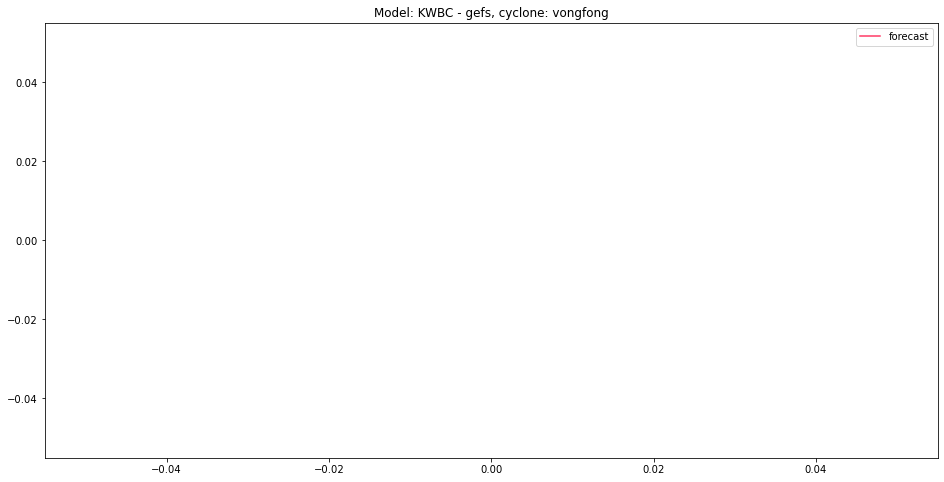

In [49]:
## Plot single cyclone, single model

# Parameters
model_num = 5  # from 0 to 8
cyclone_name = 'vongfong'  #['phanfone','vongfong']
colors = ['#ED254E','#F9DC5C','#97EAD2','#731963','#40F99B','#FF3864','#A020F0','#FF00FF','#D2691E','#00008B','#B8860B','#556B2F','#FF8C00','#ADFF2F','#FFFF00']
plot_forecast = 'y'

# Create figure
plt.figure(figsize=(16,8))

# Path relative to the 'forecast'
lat_for = results[str(model_num)][cyclone_name]['forecast']['lat']
lon_for = results[str(model_num)][cyclone_name]['forecast']['lon']

# Path relative to the average 'esemble forecast'
lat_cal = results[str(model_num)][cyclone_name]['ensemble_mean']['lat']
lon_cal = results[str(model_num)][cyclone_name]['ensemble_mean']['lon']
        

if plot_forecast == 'y':
    if lat_for.size > 1 and not all(x == 'nan' for x in lat_for):
        plt.plot(lon_for,lat_for, color=colors[model_num], label='forecast')
        plt.scatter(lon_for,lat_for, color=colors[model_num], marker='^')
    
if lat_cal.size > 1 and not all(x == 'nan' for x in lat_cal):
    plt.plot(lon_cal,lat_cal, '--', color=colors[model_num], label='ensemble')
    plt.scatter(lon_cal,lat_cal, color=colors[model_num])
    
    # Retrieve the date and time at which the forecast was made
    start_ens = results[str(model_num)][cyclone_name]['ensemble']['start']
    
    # Time points labels
    for label, x, y in zip([start_ens]+nhours_list[1:], lon_cal, lat_cal):
        plt.annotate(
            label,
            xy=(x, y), xytext=(0, -23),
            textcoords='offset points', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.22', fc='white'),
            )
    
# Title and legend
plt.title('Model: '+results[str(model_num)]['model_name']+', cyclone: '+cyclone_name);
plt.legend();

### Multimodel model plot without map

In [ ]:
## Plot single cyclone, multimodel

# Parameters
colors = ['#ED254E','#F9DC5C','#97EAD2','#731963','#40F99B','#FF3864','#A020F0','#FF00FF','#D2691E','#00008B','#B8860B','#556B2F','#FF8C00','#ADFF2F','#FFFF00']
cyclone_name = 'vongfong'  #['phanfone','vongfong']
plot_forecast = 'n'

# Create figure
plt.figure(figsize=(15,15))

# Loop over models
for model_num in range(len(results)):

    # Path relative to the 'forecast'
    lat_for = results[str(model_num)][cyclone_name]['forecast']['lat']
    lon_for = results[str(model_num)][cyclone_name]['forecast']['lon']

    # Path relative to the average 'esemble forecast'
    lat_cal = results[str(model_num)][cyclone_name]['ensemble_mean']['lat']
    lon_cal = results[str(model_num)][cyclone_name]['ensemble_mean']['lon']

    if plot_forecast == 'y':
        if lat_for.size > 1 and not all(x == 'nan' for x in lat_for):
            plt.plot(lon_for,lat_for, color=colors[model_num])
            plt.scatter(lon_for,lat_for, color=colors[model_num], marker='^')

    if lat_cal.size > 1 and not all(x == 'nan' for x in lat_cal):
        
        # Retrieve the date and time at which the forecast was made
        start_ens = results[str(model_num)][cyclone_name]['ensemble_mean']['start']
        
        plt.plot(lon_cal,lat_cal, '--', color=colors[model_num], label=results[str(model_num)]['model_name']+', '+str(results[str(model_num)][cyclone_name]['num_members_ensemble'])+' members, starting date: '+start_ens)
        plt.scatter(lon_cal,lat_cal, color=colors[model_num])
        
        # Time points labels
        for label, x, y in zip(nhours_list, lon_cal, lat_cal):
            plt.annotate(
                label,
                xy=(x, y), xytext=(0, -15),
                textcoords='offset points', ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.22', fc=colors[model_num], alpha=0.2),
                )
    
# Title and legend
plt.title('Cyclone: '+cyclone_name, fontweight='bold', fontsize=18)
plt.legend()

### Plot all times of all ensemble members for a certain cyclone (might give errors)

In [ ]:
# ## Plot single cyclone, multimodel, with map

# # Parameters
# colors = ['#ED254E','#F9DC5C','#97EAD2','#731963','#40F99B','#FF3864','#A020F0','#FF00FF','#D2691E','#00008B','#B8860B','#556B2F','#FF8C00','#ADFF2F','#FFFF00']
# cyclone_name = 'vongfong'  #['phanfone','vongfong']
# plot_forecast = 'n'
# font_size = 14
# position_legend_distance = 0.8


# # Create figure
# fig = plt.figure(figsize=(15,15))

# matplotlib.rc('xtick', labelsize=font_size) 
# matplotlib.rc('ytick', labelsize=font_size) 

# ## Create countours countries
# ax = plt.axes(projection=ccrs.PlateCarree())
# # ax.stock_img()

# if 'lat_min' in globals():
#     del lat_min, lat_max, lon_min, lon_max

# # Loop over models
# for model_num in range(len(results)):
    
#     if results[str(model_num)][cyclone_name]['num_members_ensemble']>0:
    
#         for member in range(results[str(model_num)][cyclone_name]['num_members_ensemble']):

#             # Path relative to the average 'esemble forecast'
#             lat_cal = results[str(model_num)][cyclone_name]['ensemble']['lat'][member,:]
#             lon_cal = results[str(model_num)][cyclone_name]['ensemble']['lon'][member,:]

#             if lat_cal.size > 1 and not all(x == 'nan' for x in lat_cal):

#                 # Find min and max of lat and lon
#                 try:
#                     lat_min = min(lat_min, np.nanmin(lat_cal))
#                     lat_max = max(lat_max, np.nanmax(lat_cal))
#                     lon_min = min(lon_min, np.nanmin(lon_cal))
#                     lon_max = max(lon_max, np.nanmax(lon_cal))
#                 except:
#                     lat_min = np.nanmin(lat_cal)
#                     lat_max = np.nanmax(lat_cal)
#                     lon_min = np.nanmin(lon_cal)
#                     lon_max = np.nanmax(lon_cal)

#                 r = random.random()
#                 b = random.random()
#                 g = random.random()
#                 color = (r, g, b)

#                 ax.plot(lon_cal,lat_cal, '--', color=color, label=results[str(model_num)]['model_name']+', '+str(results[str(model_num)][cyclone_name]['num_members_ensemble'])+' members', transform=ccrs.Geodetic())
#                 ax.scatter(lon_cal,lat_cal, color=color)

#                 # Time points labels
#                 for label, x, y in zip(nhours_list, lon_cal, lat_cal):
#                     ax.annotate(
#                         label,
#                         xy=(x, y), xytext=(0, -15),
#                         textcoords='offset points', ha='center', va='center',
#                         bbox=dict(boxstyle='round,pad=0.22', fc=color, alpha=0.2),
#                         )
       
    
# # Restrict to certain latitudes - longitudes
# ax.set_extent([lon_min-1, lon_max+1, lat_min-1, lat_max+1], crs=ccrs.PlateCarree())
# ax.coastlines(resolution='50m', alpha=0.3)
# gl = ax.gridlines(color='gray', draw_labels=True)

# gl.xlabel_style = {'fontsize': font_size}
# gl.ylabel_style = {'fontsize': font_size}
    
# # Title and legend
# plt.title('Cyclone: '+cyclone_name, fontweight='bold', fontsize=font_size*3/2, y=1.06)
# # plt.legend(fontsize=font_size, framealpha=1);

# ax.annotate('100 km', xy=(lon_min-position_legend_distance+100/220,lat_min-position_legend_distance+0.1), horizontalalignment='center', fontsize=font_size)
# ax.arrow(lon_min-position_legend_distance, lat_min-position_legend_distance, 100/110, 0, color='k', shape='full', lw=5, length_includes_head=True, head_width=0) 

### Multimodel plot (ensemble means) with map

In [ ]:
## Plot single cyclone, multimodel, with map

# Parameters
colors = ['#ED254E','#F9DC5C','#97EAD2','#731963','#40F99B','#FF3864','#A020F0','#FF00FF','#D2691E','#00008B','#B8860B','#556B2F','#FF8C00','#ADFF2F','#FFFF00']
cyclone_name = 'vongfong'  #['phanfone','vongfong']
plot_forecast = 'n'
font_size = 14
position_legend_distance = 0.8

institutes_selection = ['kwbc', 'rjtd', 'egrr', 'ecmf']
# institutes_selection = ['kwbc', 'egrr', 'ecmf']

# Create figure
fig = plt.figure(figsize=(15,15))

matplotlib.rc('xtick', labelsize=font_size) 
matplotlib.rc('ytick', labelsize=font_size) 

## Create countours countries
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.stock_img()

if 'lat_min' in globals():
    del lat_min, lat_max, lon_min, lon_max

# Loop over models
for model_num in range(len(results)):
    
    if results[str(model_num)]['model_name'].split('-')[0].strip().lower() in institutes_selection:

        # Path relative to the 'forecast'
        lat_for = results[str(model_num)][cyclone_name]['forecast']['lat']
        lon_for = results[str(model_num)][cyclone_name]['forecast']['lon']

        # Path relative to the average 'esemble forecast'
        lat_cal = results[str(model_num)][cyclone_name]['ensemble_mean']['lat']
        lon_cal = results[str(model_num)][cyclone_name]['ensemble_mean']['lon']

        if plot_forecast == 'y':
            if lat_for.size > 1 and not all(x == 'nan' for x in lat_for):
                ax.plot(lon_for,lat_for, color=colors[model_num], transform=ccrs.Geodetic())
                ax.scatter(lon_for,lat_for, color=colors[model_num])

        if lat_cal.size > 1 and not all(x == 'nan' for x in lat_cal):

            # Find min and max of lat and lon
            try:
                lat_min = min(lat_min, np.nanmin(lat_cal))
                lat_max = max(lat_max, np.nanmax(lat_cal))
                lon_min = min(lon_min, np.nanmin(lon_cal))
                lon_max = max(lon_max, np.nanmax(lon_cal))
            except:
                lat_min = np.nanmin(lat_cal)
                lat_max = np.nanmax(lat_cal)
                lon_min = np.nanmin(lon_cal)
                lon_max = np.nanmax(lon_cal)

            # Retrieve the date and time at which the forecast was made
            start_ens = results[str(model_num)][cyclone_name]['ensemble_mean']['start']

            ax.plot(lon_cal,lat_cal, '--', color=colors[model_num], label=results[str(model_num)]['model_name']+', '+str(results[str(model_num)][cyclone_name]['num_members_ensemble'])+' members, starting date: '+start_ens, transform=ccrs.Geodetic())
            ax.scatter(lon_cal,lat_cal, color=colors[model_num])

            # Time points labels
            for label, x, y in zip(nhours_list, lon_cal, lat_cal):
                ax.annotate(
                    label,
                    xy=(x, y), xytext=(0, -15),
                    textcoords='offset points', ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.22', fc=colors[model_num], alpha=0.2),
                    )
       
    
# Restrict to certain latitudes - longitudes
ax.set_extent([lon_min-1, lon_max+1, lat_min-1, lat_max+1], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m', alpha=0.3)
gl = ax.gridlines(color='gray', draw_labels=True)

gl.xlabel_style = {'fontsize': font_size}
gl.ylabel_style = {'fontsize': font_size}
    
# Title and legend
plt.title('Cyclone: '+cyclone_name, fontweight='bold', fontsize=font_size*3/2, y=1.06)
plt.legend(fontsize=font_size, framealpha=1);

ax.annotate('100 km', xy=(lon_min-position_legend_distance+100/220,lat_min-position_legend_distance+0.1), horizontalalignment='center', fontsize=font_size)
ax.arrow(lon_min-position_legend_distance, lat_min-position_legend_distance, 100/110, 0, color='k', shape='full', lw=5, length_includes_head=True, head_width=0)
# fig.savefig(figures_folder+'tracks_'+cyclone_name+'.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0.3)
# fig.savefig(figures_folder+'tracks_'+cyclone_name+'.png', format='png', dpi=300, bbox_inches = 'tight', pad_inches = 0.3)

### Multimodel plot (ensemble means) with map, where starting times have been made uniform

In [ ]:
## Plot single cyclone, multimodel, with map

# Parameters
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
cyclone_name = 'vongfong'  #['phanfone','vongfong']
plot_forecast = 'n'
font_size = 14
position_legend_distance = 0.8

institutes_selection = ['kwbc', 'rjtd', 'egrr', 'ecmf']
# institutes_selection = ['kwbc', 'egrr', 'ecmf']

# Cyclone-specific
start_day_hour = [12,12]
start_month_year = ['05','2020']


# Create figure
fig = plt.figure(figsize=(15,15))

matplotlib.rc('xtick', labelsize=font_size) 
matplotlib.rc('ytick', labelsize=font_size) 

## Create countours countries
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.stock_img()

if 'lat_min' in globals():
    del lat_min, lat_max, lon_min, lon_max

# Loop over models
for model_num in range(len(results)):
    
    if results[str(model_num)]['model_name'].split('-')[0].strip().lower() in institutes_selection:

        # Path relative to the 'forecast'
        lat_for = results[str(model_num)][cyclone_name]['forecast']['lat']
        lon_for = results[str(model_num)][cyclone_name]['forecast']['lon']

        # Path relative to the average 'esemble forecast'
        lat_cal = results[str(model_num)][cyclone_name]['ensemble_mean']['lat']
        lon_cal = results[str(model_num)][cyclone_name]['ensemble_mean']['lon']

        if plot_forecast == 'y':
            if lat_for.size > 1 and not all(x == 'nan' for x in lat_for):
                ax.plot(lon_for,lat_for, color=colors[model_num], transform=ccrs.Geodetic())
                ax.scatter(lon_for,lat_for, color=colors[model_num])

        if lat_cal.size > 1 and not all(x == 'nan' for x in lat_cal):

            # Find min and max of lat and lon
            try:
                lat_min = min(lat_min, np.nanmin(lat_cal))
                lat_max = max(lat_max, np.nanmax(lat_cal))
                lon_min = min(lon_min, np.nanmin(lon_cal))
                lon_max = max(lon_max, np.nanmax(lon_cal))
            except:
                lat_min = np.nanmin(lat_cal)
                lat_max = np.nanmax(lat_cal)
                lon_min = np.nanmin(lon_cal)
                lon_max = np.nanmax(lon_cal)

            # Retrieve the date and time at which the forecast was made
            start_ens = results[str(model_num)][cyclone_name]['ensemble_mean']['start']

            day = int(start_ens[8:10])
            hour = int(start_ens[12:14])

            delay = (day - start_day_hour[0])*24 + hour - start_day_hour[1]

            ax.plot(lon_cal,lat_cal, '--', color=colors[model_num], label=results[str(model_num)]['model_name']+', '+str(results[str(model_num)][cyclone_name]['num_members_ensemble'])+' members', transform=ccrs.Geodetic())
            ax.scatter(lon_cal,lat_cal, color=colors[model_num])

            # Time points labels
            for label, x, y in zip([j+delay for j in nhours_list], lon_cal, lat_cal):
                ax.annotate(
                    label,
                    xy=(x, y), xytext=(0, -15),
                    textcoords='offset points', ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.22', fc=colors[model_num], alpha=0.2),
                    )
       
    
# Restrict to certain latitudes - longitudes
ax.set_extent([lon_min-1, lon_max+1, lat_min-1, lat_max+1], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m', alpha=0.3)
gl = ax.gridlines(color='gray', draw_labels=True)

gl.xlabel_style = {'fontsize': font_size}
gl.ylabel_style = {'fontsize': font_size}
    
# Title and legend
plt.title('Cyclone: '+cyclone_name+'; starting date: '+start_month_year[0]+'/'+str(start_day_hour[0])+'/'+start_month_year[1]+', '+str(start_day_hour[1])+':00:00', fontweight='bold', fontsize=font_size*3/2, y=1.06)
plt.legend(fontsize=font_size, framealpha=1);

ax.annotate('100 km', xy=(lon_min-position_legend_distance+100/220,lat_min-position_legend_distance+0.1), horizontalalignment='center', fontsize=font_size)
ax.arrow(lon_min-position_legend_distance, lat_min-position_legend_distance, 100/110, 0, color='k', shape='full', lw=5, length_includes_head=True, head_width=0) 

### Multimodel plot (ensemble means and multimodel mean) with map, where starting times have been made uniform

In [ ]:
## Plot single cyclone, multimodel, with map

# Parameters
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99']
cyclone_name = 'vongfong'  #['phanfone','vongfong']
font_size = 14
position_legend_distance = 0.8


institutes_selection = ['kwbc', 'rjtd', 'egrr', 'ecmf']
# institutes_selection = ['kwbc', 'ecmf']

# Cyclone-specific
start_day_hour = [12,12]
start_month_year = ['02','2020']


# Create figure
fig = plt.figure(figsize=(15,15))

matplotlib.rc('xtick', labelsize=font_size) 
matplotlib.rc('ytick', labelsize=font_size) 

## Create countours countries
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.stock_img()

if 'lat_min' in globals():
    del lat_min, lat_max, lon_min, lon_max

lats_models = {}
lons_models = {}

# Loop over models
for model_num in range(len(results)):
    
    if results[str(model_num)]['model_name'].split('-')[0].strip().lower() in institutes_selection:

        # Path relative to the average 'esemble forecast'
        lat_cal = results[str(model_num)][cyclone_name]['ensemble_mean']['lat']
        lon_cal = results[str(model_num)][cyclone_name]['ensemble_mean']['lon']

        if lat_cal.size > 1 and not all(x == 'nan' for x in lat_cal):

            # Find min and max of lat and lon
            try:
                lat_min = min(lat_min, np.nanmin(lat_cal))
                lat_max = max(lat_max, np.nanmax(lat_cal))
                lon_min = min(lon_min, np.nanmin(lon_cal))
                lon_max = max(lon_max, np.nanmax(lon_cal))
            except:
                lat_min = np.nanmin(lat_cal)
                lat_max = np.nanmax(lat_cal)
                lon_min = np.nanmin(lon_cal)
                lon_max = np.nanmax(lon_cal)

            # Retrieve the date and time at which the forecast was made
            start_ens = results[str(model_num)][cyclone_name]['ensemble_mean']['start']

            day = int(start_ens[8:10])
            hour = int(start_ens[12:14])

            delay = (day - start_day_hour[0])*24 + hour - start_day_hour[1]

            n_hours_with_delay = [j+delay for j in nhours_list]

            for ind_h, h in enumerate(n_hours_with_delay):

                if h not in lats_models:
                    lats_models[h] = []
                    lons_models[h] = []

                lats_models[h] += list(results[str(model_num)][cyclone_name]['ensemble']['lat'][:,ind_h])
                lons_models[h] += list(results[str(model_num)][cyclone_name]['ensemble']['lon'][:,ind_h])

            ax.plot(lon_cal,lat_cal, '--', color=colors[model_num], label=results[str(model_num)]['model_name']+', '+str(results[str(model_num)][cyclone_name]['num_members_ensemble'])+' members', transform=ccrs.Geodetic())
            ax.scatter(lon_cal,lat_cal, color=colors[model_num])

            # Time points labels
            for label, x, y in zip([j+delay for j in nhours_list], lon_cal, lat_cal):
                ax.annotate(
                    label,
                    xy=(x, y), xytext=(0, -15),
                    textcoords='offset points', ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.22', fc=colors[model_num], alpha=0.2),
                    )
          
    
n_hours_averages = []
lats_averages = []
lons_averages = []
lats_std = []
lons_std = []

for k in lats_models:
    if k<=time_limit:
        n_hours_averages.append(k)
        lats_averages.append(np.nanmean(lats_models[k]))
        lons_averages.append(np.nanmean(lons_models[k]))
        lats_std.append(np.nanstd(lats_models[k]))
        lons_std.append(np.nanstd(lats_models[k]))
        
order_times = [int(x) for x in np.argsort(n_hours_averages)]
n_hours_averages = np.sort(n_hours_averages)
lats_averages = np.array(lats_averages)[order_times]
lons_averages = np.array(lons_averages)[order_times]
lats_std = np.array(lats_std)[order_times]
lons_std = np.array(lons_std)[order_times]
    
ax.plot(lons_averages,lats_averages, '-', color=colors[model_num+1], linewidth=2.5, label='Multimodel mean', transform=ccrs.Geodetic())
ax.scatter(lons_averages,lats_averages, color=colors[model_num+1])

# Time points labels
for label, x, y in zip(n_hours_averages, lons_averages, lats_averages):
    ax.annotate(
        label,
        xy=(x, y), xytext=(0, -15),
        textcoords='offset points', ha='center', va='center',
        bbox=dict(boxstyle='round,pad=0.22', fc=colors[model_num+1], alpha=0.2),
        )
       
    
# Restrict to certain latitudes - longitudes
ax.set_extent([lon_min-1, lon_max+1, lat_min-1, lat_max+1], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m', alpha=0.3)
gl = ax.gridlines(color='gray', draw_labels=True)

gl.xlabel_style = {'fontsize': font_size}
gl.ylabel_style = {'fontsize': font_size}
    
# Title and legend
plt.title('Cyclone: '+cyclone_name+'; starting date: '+start_month_year[0]+'/'+str(start_day_hour[0])+'/'+start_month_year[1]+', '+str(start_day_hour[1])+':00:00', fontweight='bold', fontsize=font_size*3/2, y=1.06)
plt.legend(fontsize=font_size, framealpha=1);

ax.annotate('100 km', xy=(lon_min-position_legend_distance+100/220,lat_min-position_legend_distance+0.1), horizontalalignment='center', fontsize=font_size)
ax.arrow(lon_min-position_legend_distance, lat_min-position_legend_distance, 100/110, 0, color='k', shape='full', lw=5, length_includes_head=True, head_width=0) 

# fig.savefig(figures_folder+'tracks_with_mean_'+cyclone_name+'.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0.3)
# fig.savefig(figures_folder+'tracks_with_mean_'+cyclone_name+'.png', format='png', dpi=300, bbox_inches = 'tight', pad_inches = 0.3)

### Multimodel mean and probability with map

In [ ]:
## Plot single cyclone, multimodel, with map

# Parameters
colors = ['#ED254E','#F9DC5C','#97EAD2','#731963','#40F99B','#FF3864','#A020F0','#FF00FF','#D2691E','#00008B','#B8860B','#556B2F','#FF8C00','#ADFF2F','#FFFF00']
cyclone_name = 'vongfong'  #['phanfone','vongfong']
font_size = 14
position_legend_distance = 0.8

# Cyclone-specific
start_day_hour = [12,12]
start_month_year = ['05','2020']


# Create figure
fig = plt.figure(figsize=(15,15))

matplotlib.rc('xtick', labelsize=font_size) 
matplotlib.rc('ytick', labelsize=font_size) 

## Create countours countries
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.stock_img()
   
m_x = lons_averages 
m_y = lats_averages

up_x = np.array(lons_averages)+np.array(lons_std)
up_y = np.array(lats_averages)+np.array(lats_std)

down_x = np.array(lons_averages)-np.array(lons_std)
down_y = np.array(lats_averages)-np.array(lats_std)
    
ax.plot(m_x,m_y, '-', color=colors[model_num+1], linewidth=2.5, label='Multimodel mean', transform=ccrs.Geodetic())
ax.plot(up_x,up_y, '--', color=colors[model_num+1], linewidth=1, label='1 std deviation', transform=ccrs.Geodetic())
ax.plot(down_x,down_y, '--', color=colors[model_num+1], linewidth=1, transform=ccrs.Geodetic())

ax.scatter(lons_averages,lats_averages, color=colors[model_num+1])

# Time points labels
for label, x, y in zip(n_hours_averages, lons_averages, lats_averages):
    ax.annotate(
        label,
        xy=(x, y), xytext=(0, -15),
        textcoords='offset points', ha='center', va='center',
        bbox=dict(boxstyle='round,pad=0.22', fc=colors[model_num+1], alpha=0.05),
        )
    
    
# Color inside std deviations

k_list = np.linspace(0.2,2,50)[::-1];
alpha_list = np.linspace(0.02,0.03,50);

for j,k in enumerate(k_list):

    up_x = np.array(lons_averages)+np.array(lons_std)*k
    up_y = np.array(lats_averages)+np.array(lats_std)*k

    down_x = np.array(lons_averages)-np.array(lons_std)*k
    down_y = np.array(lats_averages)-np.array(lats_std)*k

    x_list = []
    y_list = []

    x_list.append(m_x[0])
    y_list.append(m_y[0])

    for i in range(len(up_x)):
        x_list.append(up_x[i])
        y_list.append(up_y[i])

    x_list.append(m_x[-1])
    y_list.append(m_y[-1])

    for i in range(len(up_x)):
        x_list.append(down_x[::-1][i])
        y_list.append(down_y[::-1][i])

    plt.fill(x_list, y_list, color=colors[model_num+1], alpha=alpha_list[j])
       
    
# Restrict to certain latitudes - longitudes
ax.set_extent([lon_min-1, lon_max+1, lat_min-1, lat_max+1], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m', alpha=0.3)
gl = ax.gridlines(color='gray', draw_labels=True)

gl.xlabel_style = {'fontsize': font_size}
gl.ylabel_style = {'fontsize': font_size}
    
# Title and legend
plt.title('Cyclone: '+cyclone_name+'; starting date: '+start_month_year[0]+'/'+str(start_day_hour[0])+'/'+start_month_year[1]+', '+str(start_day_hour[1])+':00:00', fontweight='bold', fontsize=font_size*3/2, y=1.06)
plt.legend(fontsize=font_size, framealpha=1);

ax.annotate('100 km', xy=(lon_min-position_legend_distance+100/220,lat_min-position_legend_distance+0.1), horizontalalignment='center', fontsize=font_size)
ax.arrow(lon_min-position_legend_distance, lat_min-position_legend_distance, 100/110, 0, color='k', shape='full', lw=5, length_includes_head=True, head_width=0) 

# fig.savefig(figures_folder+'tracks_probabilistic_'+cyclone_name+'.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0.3)
# fig.savefig(figures_folder+'tracks_probabilistic_'+cyclone_name+'.png', format='png', dpi=300, bbox_inches = 'tight', pad_inches = 0.3)

### Comparison between multimodel mean, UCL and observations

In [ ]:
## Plot single cyclone, multimodel, with map

# Parameters
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99']
cyclone_name = 'vongfong'  #['phanfone','vongfong']
font_size = 14
position_legend_distance = 0.8
start_day_hour = [12,12]
start_month_year = ['05','2020']

plot_models = 'n'
plot_std = 'n'
plot_ucl = 'y'
plot_obs = 'y'

# name_plot = 'track_mean_obs'
name_plot = 'track_UCL_obs'


# Create figure
fig = plt.figure(figsize=(15,15))

matplotlib.rc('xtick', labelsize=font_size) 
matplotlib.rc('ytick', labelsize=font_size) 

## Create countours countries
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.stock_img()


# Plot model mean 
r = random.random()
b = random.random()
g = random.random()
color = (r, g, b)
i = 0
color = colors[i]

m_x = lons_averages 
m_y = lats_averages

up_x = np.array(lons_averages)+np.array(lons_std)
up_y = np.array(lats_averages)+np.array(lats_std)

down_x = np.array(lons_averages)-np.array(lons_std)
down_y = np.array(lats_averages)-np.array(lats_std)
    
if plot_models == 'y':
    ax.plot(m_x,m_y, '--', color=color, linewidth=2.5, label='Multimodel mean', transform=ccrs.Geodetic())
    ax.scatter(m_x,m_y, color=color)
    
    # Time points labels
    for label, x, y in zip(n_hours_averages, lons_averages, lats_averages):
        ax.annotate(
            label,
            xy=(x, y), xytext=(0, -15),
            textcoords='offset points', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.22', fc=color, alpha=0.2),
            )
    
if plot_std == 'y':
    ax.plot(up_x,up_y, '--', color=color, linewidth=1, transform=ccrs.Geodetic())
    ax.plot(down_x,down_y, '--', color=color, linewidth=1, transform=ccrs.Geodetic())


# Color inside std deviations

x_list = []
y_list = []

x_list.append(m_x[0])
y_list.append(m_y[0])

for i in range(len(up_x)):
    x_list.append(up_x[i])
    y_list.append(up_y[i])
    
x_list.append(m_x[-1])
y_list.append(m_y[-1])

for i in range(len(up_x)):
    x_list.append(down_x[::-1][i])
    y_list.append(down_y[::-1][i])

if plot_std == 'y':
    ax.fill(x_list, y_list, color=color, alpha=0.1)
    
# Plot UCL
hours = ['00','06','12','18']
days = [11,12,13,14,15,16]

times_total = [str(d)+h for d in days for h in hours]
time = str(start_day_hour[0])+str(start_day_hour[1])

ind_times_total = times_total.index(time)

for i,t in enumerate(times_total[ind_times_total-1:ind_times_total+2]):
    try:
        
        day = int(t[:2])
        hour = int(t[2:])
        
        delay = (day - start_day_hour[0])*24 + hour - start_day_hour[1]
        
        
        f = Dataset('data/nc/202001W_gust_202004'+t+'.nc')
        lt = f.variables['forecast lead time'][:]
        ind_lt_max = np.where(lt==time_limit)[0][0]
        lons = f.variables['storm forecast longitude'][:ind_lt_max+1]
        lats = f.variables['storm forecast latitude'][:ind_lt_max+1]
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        
        if plot_ucl == 'y':
            ax.plot(lons,lats,color=color,label='UCL ('+str(delay)+' hours)')
            ax.scatter(lons,lats, color=color)

            # Time points labels
            for label, x, y in zip([j+delay for j in lt[:ind_lt_max+1]], lons, lats):
                ax.annotate(
                    label,
                    xy=(x, y), xytext=(0, -15),
                    textcoords='offset points', ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.22', fc=color, alpha=0.2),
                    )
        
    except:
        pass
    
    
# Plot observations
times_total = [str(d)+h for d in days for h in hours]
time = str(start_day_hour[0])+str(start_day_hour[1])
        
day = int(obs['start'][:2])
hour = int(obs['start'][2:])

delay = (day - start_day_hour[0])*24 + hour - start_day_hour[1]

lons = obs['track'][:,1]
lats = obs['track'][:,0]
r = random.random()
b = random.random()
g = random.random()
color = (r, g, b)
i += 1
color = colors[i]

if plot_obs == 'y':
    ax.plot(lons,lats,color=color,linestyle='dotted',label='Observations ('+str(delay)+' hours)')
    ax.scatter(lons, lats, marker='d', color=color)

    # Time points labels
    for label, x, y in zip([j+delay for j in list(obs['time'])], lons, lats):
        ax.annotate(
            label,
            xy=(x, y), xytext=(0, -15),
            textcoords='offset points', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.22', fc=color, alpha=0.2),
            )
       
    
# Restrict to certain latitudes - longitudes
ax.set_extent([lon_min-1, lon_max+1, lat_min-1, lat_max+1], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m', alpha=0.3)
gl = ax.gridlines(color='gray', draw_labels=True)

gl.xlabel_style = {'fontsize': font_size}
gl.ylabel_style = {'fontsize': font_size}
    
# Title and legend
plt.title('Cyclone: '+cyclone_name+'; starting date: '+start_month_year[0]+'/'+str(start_day_hour[0])+'/'+start_month_year[1]+', '+str(start_day_hour[1])+':00:00', fontweight='bold', fontsize=font_size*3/2, y=1.06)
plt.legend(fontsize=font_size, framealpha=1);

ax.annotate('100 km', xy=(lon_min-position_legend_distance+100/220,lat_min-position_legend_distance+0.1), horizontalalignment='center', fontsize=font_size);
ax.arrow(lon_min-position_legend_distance, lat_min-position_legend_distance, 100/110, 0, color='k', shape='full', lw=5, length_includes_head=True, head_width=0);

# fig.savefig(figures_folder+name_plot+'_'+cyclone_name+'.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0.3)
# fig.savefig(figures_folder+name_plot+'_'+cyclone_name+'.png', format='png', dpi=300, bbox_inches = 'tight', pad_inches = 0.3)

### Initial conditions

In [ ]:
## Plot single cyclone, multimodel, with map

# Parameters
colors = ['#ED254E','#F9DC5C','#97EAD2','#731963','#40F99B','#FF3864','#A020F0','#FF00FF','#D2691E','#00008B','#B8860B','#556B2F','#FF8C00','#ADFF2F','#FFFF00']
cyclone_name = 'vongfong'  #['phanfone','vongfong']
font_size = 14
position_legend_distance = 0.8
marker = itertools.cycle(('.', 'o', 'v', 's', 'P', '*', '+', 'x', 'd'))
times = []


# Create figure
fig = plt.figure(figsize=(15,15))

matplotlib.rc('xtick', labelsize=font_size) 
matplotlib.rc('ytick', labelsize=font_size) 

## Create countours countries
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.stock_img()

if 'lat_min' in globals():
    del lat_min, lat_max, lon_min, lon_max

# Loop over models
for model_num in range(len(results)):
    
    r = random.random()
    b = random.random()
    g = random.random()
    color = (r, g, b)
    
    # Initial points relative to analysis
    coord_cal = np.array(results[str(model_num)][cyclone_name]['initial']['analysis']['coord'])
    
    if coord_cal.size > 1 and not all(x == 'nan' for x in coord_cal) and not coord_cal[0] == 0:
        
        lat_cal = coord_cal[0]
        lon_cal = coord_cal[1]
        
        # Retrieve the date and time at which the forecast was made
        start_ens = results[str(model_num)][cyclone_name]['initial']['analysis']['date']
        
        day = int(start_ens[8:10])
        hour = int(start_ens[12:14])
        
        if day+hour not in times:
            times.append(day+hour)
        
#         ax.plot(lon_cal,lat_cal, '--', color=colors[model_num], label=results[str(model_num)]['model_name']+', '+str(results[str(model_num)][cyclone_name]['num_members_ensemble'])+' members, starting date: '+start_ens, transform=ccrs.Geodetic())
        ax.scatter(lon_cal,lat_cal, s=60, marker = next(marker), color=color, label=results[str(model_num)]['model_name']+', analysis, date: '+start_ens, transform=ccrs.Geodetic())
       
    # Initial points relative to forecast
    coord_cal = np.array(results[str(model_num)][cyclone_name]['initial']['forecast']['coord'])
    
    if coord_cal.size > 1 and not all(x == 'nan' for x in coord_cal) and not coord_cal[0] == 0:
        
        lat_cal = coord_cal[0]
        lon_cal = coord_cal[1]
        
        # Retrieve the date and time at which the forecast was made
        start_ens = results[str(model_num)][cyclone_name]['initial']['forecast']['date']
        
        day = int(start_ens[8:10])
        hour = int(start_ens[12:14])
        
        if day+hour not in times:
            times.append(day+hour)
        
#         ax.plot(lon_cal,lat_cal, '--', color=colors[model_num], label=results[str(model_num)]['model_name']+', '+str(results[str(model_num)][cyclone_name]['num_members_ensemble'])+' members, starting date: '+start_ens, transform=ccrs.Geodetic())
        ax.scatter(lon_cal,lat_cal, s=60, marker = next(marker), color=color, label=results[str(model_num)]['model_name']+', forecast, date: '+start_ens, transform=ccrs.Geodetic())


    # Initial points relative to ensemble
    coord_cal = np.array(results[str(model_num)][cyclone_name]['initial']['ensemble']['coord'])
    
    if coord_cal.size > 1 and not all(x == 'nan' for x in coord_cal):
        
        lat_cal = coord_cal[:,0]
        lon_cal = coord_cal[:,1]
        
        # Find min and max of lat and lon
        if not lon_cal[0] == 0:
            try:
                lat_min = min(lat_min, np.nanmin(lat_cal))
                lat_max = max(lat_max, np.nanmax(lat_cal))
                lon_min = min(lon_min, np.nanmin(lon_cal))
                lon_max = max(lon_max, np.nanmax(lon_cal))
            except:
                lat_min = np.nanmin(lat_cal)
                lat_max = np.nanmax(lat_cal)
                lon_min = np.nanmin(lon_cal)
                lon_max = np.nanmax(lon_cal)

        # Retrieve the date and time at which the forecast was made
        start_ens = results[str(model_num)][cyclone_name]['initial']['ensemble']['date'][0]
        
        day = start_ens[3:5]
        hour = start_ens[12:14]
        
        if day+hour not in times:
            times.append(day+hour)
        
#         ax.plot(lon_cal,lat_cal, '--', color=colors[model_num], label=results[str(model_num)]['model_name']+', '+str(results[str(model_num)][cyclone_name]['num_members_ensemble'])+' members, starting date: '+start_ens, transform=ccrs.Geodetic())
        if not lon_cal[0] == 0:
            ax.scatter(lon_cal,lat_cal, s=80, marker = next(marker), color=color, label=results[str(model_num)]['model_name']+',  ensemble, date: '+start_ens, transform=ccrs.Geodetic())
       
    
# UCL data

r = random.random()
b = random.random()
g = random.random()
color = (r, g, b)

for i, t in enumerate(times):
    try:
        f = Dataset('data/nc/202001W_gust_202004'+t+'.nc')
        lons = f.variables['storm forecast longitude'][0]
        lats = f.variables['storm forecast latitude'][0]
#         ax.plot(lons,lats,color=color,label='UCL, starting date: 05/'+t[:2]+'/2020, '+t[2:]+':00:00')
        ax.scatter(lons,lats, s=80, marker = next(marker), color=color,label='UCL, date: 05/'+t[:2]+'/2020, '+t[2:]+':00:00')
        
    except:
        pass
  
    
# Observed data

r = random.random()
b = random.random()
g = random.random()
color = (r, g, b)

for t in times:
    try:
        ind = obs['time_string'].index(t)
        plt.scatter(obs['track'][ind][1],obs['track'][ind][0], s=80, marker = next(marker), color=color,label='Observations, date: 05/'+t[:2]+'/2020, '+t[2:]+':00:00')
    except:
        pass    
    
# Restrict to certain latitudes - longitudes
ax.set_extent([lon_min-1, lon_max+1, lat_min-1, lat_max+1], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m', alpha=0.3)
gl = ax.gridlines(color='gray', draw_labels=True)

gl.xlabel_style = {'fontsize': font_size}
gl.ylabel_style = {'fontsize': font_size}
    
# Title and legend
plt.title('Cyclone: '+cyclone_name+', initial conditions', fontweight='bold', fontsize=font_size*3/2, y=1.06)
plt.legend(fontsize=font_size, framealpha=1);

ax.annotate('100 km', xy=(lon_min-position_legend_distance+100/220,lat_min-position_legend_distance+0.1), horizontalalignment='center', fontsize=font_size)
ax.arrow(lon_min-position_legend_distance, lat_min-position_legend_distance, 100/110, 0, color='k', shape='full', lw=5, length_includes_head=True, head_width=0) 